In [1]:
!git lfs install
!pip install transformers

!GIT_LFS_SKIP_SMUDGE=1

Git LFS initialized.


In [2]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [3]:
num_questions = 0

In [4]:
def get_data(questions , context , answers , spans):
    """
    All are file paths , should read raw text from file 
    and convert into list
    """
    
    with open(questions) as f:
        raw_questions = f.read().splitlines()
        
    with open(context) as f:
        raw_context = f.read().splitlines()
        
    with open(answers) as f:
        raw_answers = f.read().splitlines()
        
    with open(spans) as f:
        raw_spans = f.read().splitlines()
        
    
        
    """
    answer = {'text' : ===== , 'answer_start': ======= , 'answer_end':=====}
    """
    
    Answers = []
    for iter in range(len(raw_answers)):
        dic = {}
        dic['text'] = raw_answers[iter]

#         start_index = raw_context[iter].index(dic['text'])
#         end_index = start_index + len(dic['text'])
#         dic['answer_start'] = start_index
#         dic['answer_end'] = end_index
            
        Answers.append(dic)
        
    return raw_context, raw_questions, Answers       
    

In [ ]:
# train_context, train_questions, train_answers = get_data("/kaggle/input/code-and-data/two_epochs/proj_dataset/train_data/real_que_tel.txt",
#         "/kaggle/input/code-and-data/two_epochs/proj_dataset/train_data/real_con_tel.txt",
#         "/kaggle/input/code-and-data/two_epochs/proj_dataset/train_data/real_ans_tel.txt",
#         "/kaggle/input/code-and-data/two_epochs/proj_dataset/train_data/real_span_tel.txt")

In [5]:
train_context, train_questions, train_answers = get_data("/kaggle/input/proj-code-5000samples-data/proj_5000_samples/train_data/real_que_tel.txt",
                                                        "/kaggle/input/proj-code-5000samples-data/proj_5000_samples/train_data/real_con_tel.txt",
                                                        "/kaggle/input/proj-code-5000samples-data/proj_5000_samples/train_data/real_ans_tel.txt",
                                                         "/kaggle/input/proj-code-5000samples-data/proj_5000_samples/train_data/real_span_tel.txt"
                                                        )

In [6]:
print(f"Context : {train_context[0]}")
print(f"Question : {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context : నిర్మాణపరంగా, ఈ పాఠశాలలో కాథలిక్ పాత్ర ఉంటుంది. ప్రధాన భవనం యొక్క గోల్డ్ గోపురం పైన కన్నె మేరీ యొక్క బంగారు విగ్రహం. వెంటనే ప్రధాన భవనం ముందు మరియు ఎదుర్కొంటున్న, పురాణం తో పైకి ఆయుధాలు క్రీస్తు యొక్క ఒక రాగి విగ్రహం ఉంది "అన్ని నాకు గుడ్డు". ప్రధాన భవనానికి పక్కనే పవిత్ర హృదయపు బాసిలికా ఉంది. వెనువెంటనే బాసిలికా వెనుక, ప్రార్థన మరియు ప్రతిబింబం యొక్క మారే ప్రదేశం. అది 1858 లో కన్య మేరీని సన్యాసినిగా గుర్తించదగినదిగా గుర్తించిన ఫ్రాన్స్లో, లౌర్దేస్ లోని గుహ యొక్క ప్రతిరూపం. మెయిన్ డ్రైవ్ చివరిలో (మరియు 3 విగ్రహాలు మరియు బంగారు గోపురంతో కలిపే ఒక ప్రత్యక్ష రేఖలో), మేరీ యొక్క సాధారణ, ఆధునిక రాతి విగ్రహం.
Question : నోటి డామే వద్ద పవిత్ర హృదయ బాసిలికా ఏ నిర్మాణంతో ఉంటుంది?
Answer: {'text': 'ప్రధాన భవనం'}


In [7]:
val_context, val_questions, val_answers = get_data("/kaggle/input/code-and-data/two_epochs/proj_dataset/test_data/real_que_tel.txt",
        "/kaggle/input/code-and-data/two_epochs/proj_dataset/test_data/real_con_tel.txt",
        "/kaggle/input/code-and-data/two_epochs/proj_dataset/test_data/real_ans_tel_c.txt",
        "/kaggle/input/code-and-data/two_epochs/proj_dataset/test_data/real_span_tel.txt")

403


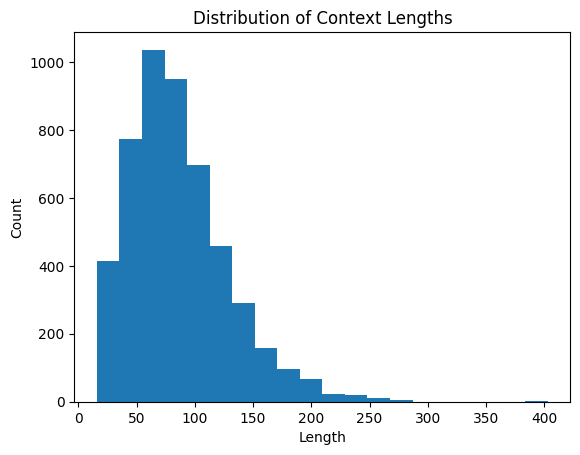

In [8]:
token_lens = []

for txt in train_context:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))
  

print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

23
5000


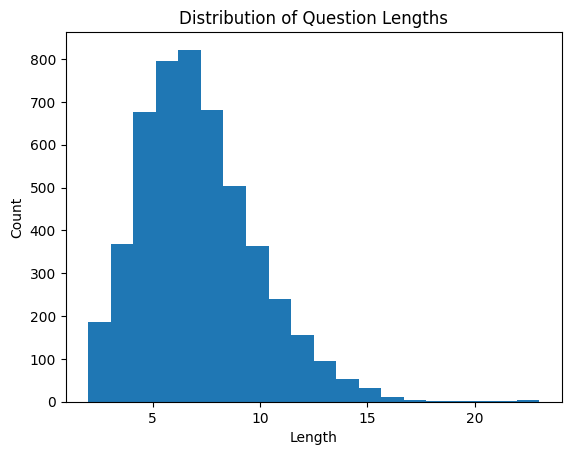

In [9]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [10]:
MAX_LENGTH = 300 

In [11]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/telugu-bert")

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

In [12]:
tokenizer.is_fast

True

In [13]:
train_encodings = tokenizer(train_questions, train_context,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings = tokenizer(val_questions, val_context,  max_length = MAX_LENGTH, truncation=True, padding = True)

In [14]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [15]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))
print(len(train_encodings['input_ids'][0]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
5000
300


In [16]:
print(train_encodings['input_ids'][1])

[104, 181827, 72028, 12300, 7246, 4280, 57435, 157371, 81367, 138, 105, 5918, 2079, 130300, 20119, 119, 873, 89694, 4886, 23345, 12300, 2252, 38728, 5918, 163040, 14252, 44680, 47546, 100592, 9275, 181060, 139568, 121, 65173, 57435, 874, 75375, 1933, 193456, 20708, 81831, 1307, 6194, 3722, 1564, 119, 1509, 42600, 1859, 60940, 2379, 1859, 5918, 878, 124042, 9123, 16967, 45088, 1564, 1859, 81782, 1163, 121, 22584, 18527, 1612, 1509, 38782, 861, 174089, 1585, 105014, 119, 74672, 90724, 15499, 878, 124042, 9123, 16967, 45088, 151330, 40295, 182382, 1585, 43451, 135828, 1859, 32386, 57615, 1307, 24921, 136919, 1450, 55880, 1585, 84278, 121, 2079, 30206, 119, 861, 18733, 122681, 4886, 119, 1509, 7707, 151330, 19054, 1859, 57435, 30209, 1859, 54377, 53183, 43595, 874, 174342, 13837, 121, 170325, 188120, 31934, 7596, 96105, 27776, 28226, 6728, 64979, 121, 3722, 1564, 157248, 27776, 28226, 6728, 46100, 1859, 28200, 130300, 1859, 2079, 92178, 3432, 104925, 160629, 4886, 25432, 6406, 119, 181827,

In [17]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding = tokenizer(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings['input_ids'][idx]) -  len(answer_encoding['input_ids']) ): #len(train_encodings['input_ids'][0])):
        match = True
        iter = 0
        for i in range(1,len(answer_encoding['input_ids']) - 1):
            iter = i
            if (answer_encoding['input_ids'][i] != train_encodings['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+iter+1
            break
    return(ret_start, ret_end)

In [18]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings.input_ids[test_rec][z : x]
print(tokenizer.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizer.decode(train_encodings['input_ids'][test_rec]))

159 165


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


బాండ్ హాల్ యొక్క దశల
బాండ్ హాల్ యొక్క దశల
[CLS] ఎక్కడ పోరాట ఐరిష్ బ్యాండ్ ఫుట్బాల్ హోమ్ క్రీడలకు నోటర్ డేమ్ స్టేడియంకు దారితీస్తుంది? [SEP] గృహ క్రీడల సమయంలో ఫుట్బాల్ గేమేడే సంప్రదాయాలు, కార్యకలాపాలు ప్రాంగణం చుట్టూ జరుగుతాయి మరియు వేర్వేరు డోర్లు సంప్రదాయ అంశంతో ( ఉదాహరణకు, జామ్ హౌస్ యొక్క రెండు - కథల బ్యానర్ ) వారి హాళ్లను అలంకరించాయి. సంప్రదాయ కార్యకలాపాలు డ్రమ్మర్ల సర్కిల్తో అర్ధరాత్రి స్ట్రోక్ వద్ద ప్రారంభమవుతాయి. ఈ సాంప్రదాయం పోరాట ఐరిష్ యొక్క బ్యాండ్ యొక్క డ్రమ్ లైన్ మరియు గడమే శనివారం మిగిలిన మిగిలిన సంబరాలలో సంగ్రహాలను ఉపయోగించుకుంటుంది. ఆ రోజు తర్వాత, ట్రంపెట్ సెక్షన్ నోటర్ డామే విజన్ మార్చ్ మరియు గోపురం కింద నోమ్ డామే అల్మా మేటర్లను ఆడతారు. బ్యాండ్ మొత్తం బాండ్ హాల్ యొక్క దశల వద్ద ఒక సంగీత కచేరీని నిర్వహిస్తుంది, అక్కడ నుండి వారు నాటకీయ డామే స్టేడియంలోకి ప్రవేశిస్తారు, అక్కడ అభిమానులను మరియు విద్యార్థులను క్యాంపస్కు ఆటగానికి దారితీస్తుంది. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [19]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
5000


In [20]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
train_encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

196


In [21]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))
print(len(valid_encodings['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
5000
1000


In [22]:
test_rec = 1
print(train_encodings['start_positions'][test_rec])
print(train_encodings['end_positions'][test_rec])
predict_answer_tokens = train_encodings.input_ids[test_rec][train_encodings['start_positions'][test_rec] : train_encodings['end_positions'][test_rec]]
print(tokenizer.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizer.decode(train_encodings['input_ids'][test_rec]))

174
178
పరిశీలకుడు
పరిశీలకుడు
[CLS] నోటి డేమే వద్ద రోజువారీ విద్యార్థి పేపర్ ఏమిటి? [SEP] అనేక ఇతర విశ్వవిద్యాలయాల్లో, నోటర్ డామే యొక్క విద్యార్థులు అనేక వార్తా మాధ్యమాల కార్యక్రమాలను నిర్వహిస్తున్నాయి. తొమ్మిది విద్యార్థి పరుగుల దుకాణాలలో మూడు వార్తాపత్రికలు, ఒక రేడియో మరియు టెలివిజన్ స్టేషన్ మరియు అనేక మ్యాగజైన్లు మరియు పత్రికలు ఉన్నాయి. సెప్టెంబరు 1876 లో ఒక పేజీ జర్నల్గా ప్రారంభమైన, పాలిస్టర్ మ్యాగజైన్ రెండుసార్లు నెలవారీగా జారీ చేయబడుతుంది మరియు యునైటెడ్ స్టేట్స్లో పురాతన నిరంతర కళాశాల ప్రచురణగా పేర్కొంది. ఇతర పత్రిక, జగ్లెర్, ఒక సంవత్సరం రెండుసార్లు విడుదల మరియు విద్యార్థి సాహిత్యం మరియు కళాత్మక దృష్టి పెడుతుంది. గోపురం ఇయర్బుక్ ఏటా ప్రచురించబడుతుంది. వార్తాపత్రికలు ప్రతిరోజూ ప్రచురించబడిన మరియు ప్రధానంగా విశ్వవిద్యాలయ మరియు ఇతర వార్తలను రిపోర్టింగ్ చేసి, నోటి డామే మరియు సెయింట్ మేరీ కళాశాల నుండి విద్యార్ధులచే నిర్వహించబడతాయి. పండితుడు మరియు గోపురం వలె కాకుండా, పరిశీలకుడు ఒక స్వతంత్ర ప్రచురణ మరియు విశ్వవిద్యాలయానికి చెందిన అధ్యాపకుల సలహాదారు లేదా సంపాదకీయ పర్యవేక్షణ లేనివాడు కాదు

In [23]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding = tokenizer(val_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings['input_ids'][idx])  -  len(answer_encoding['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding['input_ids']) - 1):
            if (answer_encoding['input_ids'][i] != valid_encodings['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [24]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
valid_encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

21


In [25]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings.input_ids[test_rec][z : x]
print(tokenizer.decode(predict_answer_tokens))
print(val_answers[test_rec]['text'])
print(tokenizer.decode(valid_encodings['input_ids'][test_rec]))

అస్తెనోస్పియర్
అస్తెనోస్పియర్
[CLS] సముద్రతీర వ్యాప్తికి మరొక పదం ఏమిటి? [SEP] 1960 వ దశకంలో, అనేక అన్వేషణలు, వాటిలో ముఖ్యమైనది సముద్రతీర వ్యాప్తి, ఎగువ మాంటిల్ యొక్క క్రస్ట్ మరియు దృఢమైన ఎగువ భాగాన్ని కలిగి ఉన్న భూమి యొక్క లిథోస్పియర్, అనేక టెక్టోనిక్ ప్లేట్లుగా విభజించబడిన ప్లాస్టిక్ వైకల్యం, ఘన, ఎగువ మాంటిల్, దీనిని అస్తెనోస్పియర్ అంటారు. ఉపరితలంపై ప్లేట్ల కదలిక మరియు మాంటిల్ యొక్క ఉష్ణప్రసరణ మధ్య సన్నిహిత కలయిక ఉంది : మహాసముద్ర ప్లేట్ కదలికలు మరియు మాంటిల్ ఉష్ణప్రసరణ ప్రవాహాలు ఎల్లప్పుడూ ఒకే దిశలో కదులుతాయి, ఎందుకంటే సముద్రపు లిథోస్పియర్ అనేది ఉష్ణప్రసరణ మాంటిల్ యొక్క దృఢమైన ఎగువ ఉష్ణ సరిహద్దు పొర. భూమి ఉపరితలంపై కదిలే దృఢమైన ప్లేట్లు మరియు ప్రసరించే మాంటిల్ మధ్య ఈ కలపడాన్ని ప్లేట్ టెక్టోనిక్స్ అంటారు. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [26]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))
print(len(train_encodings['start_positions']))
print(len(train_encodings['end_positions']))
print(len(valid_encodings['input_ids']))
print(len(valid_encodings['start_positions']))
print(len(valid_encodings['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
5000
5000
5000
1000
1000
1000


In [27]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [28]:
train_dataset = InputDataset(train_encodings)
valid_dataset = InputDataset(valid_encodings)

In [29]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [30]:
!git clone 'https://huggingface.co/l3cube-pune/telugu-bert'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning into 'telugu-bert'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), 3.06 MiB | 6.01 MiB/s, done.
Filtering content: 100% (2/2), 1.77 GiB | 61.68 MiB/s, done.


In [31]:
MODEL_PATH = '/kaggle/working/telugu-bert'

In [32]:
bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2 
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

Some weights of BertModel were not initialized from the model checkpoint at /kaggle/working/telugu-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model = QAModel()

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [35]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [36]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end
    
    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)
    
    nll = nn.NLLLoss()
    
    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)
    
    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

In [37]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [38]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
            
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [39]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            
            out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)
            
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
        #ret_loss = sum(losses)/len(losses)
    return(ret_acc)

In [40]:
EPOCHS = 2

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

torch.save(model.state_dict(), "QA_finutunemodel.pt")

Running Epoch : 100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


Train Accuracy: 0.08376597444089456      Train Loss: 4.223354499560957


Running Evaluation: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Validation Accuracy: 0.1630859375


Running Epoch : 100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


Train Accuracy: 0.273861821086262      Train Loss: 2.9955253117381573


Running Evaluation: 100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


Validation Accuracy: 0.33544921875


In [41]:
model.load_state_dict(torch.load('/kaggle/working/QA_finutunemodel.pt'))

<All keys matched successfully>

In [ ]:
def get_answer(question, context):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)
        
        answer_start = torch.argmax(output_start)  
        answer_end = torch.argmax(output_end) 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
## Finding start and end span indices

